## EDA of the NASA Turbofan dataset

In [17]:
import numpy as np
import sklearn
import pandas as pd
import statsmodels
import statsmodels.graphics.tsaplots
import dask as da
import scipy

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

plt.rcParams['figure.dpi'] = 90
#plt.rcParams['']
np.random.seed(1337)
pd.set_option("display.max_rows",1000)
pd.options.display.float_format = '{:.4f}'.format

##### Preparing the input data to be in a suitable DataFrame

In [2]:
id_col = 'unit_number'
time_col = 'time'
feature_cols = [ 'op_setting_1', 'op_setting_2', 'op_setting_3'] + ['sensor_{:d}_reading'.format(x) for x in range(1,22)]
column_names = [id_col, time_col] + feature_cols
np.set_printoptions(suppress=True, threshold=10000)

train_orig = pd.read_csv('../../keras-wtte-rnn/train.csv', header=None, names=column_names)
test_x_orig = pd.read_csv('../../keras-wtte-rnn/test_x.csv', header=None, names=column_names)
test_y_orig = pd.read_csv('../../keras-wtte-rnn/test_y.csv', header=None, names=['T'])

# This will later be used in the feature generation. Background is that for the test set, we want to map the remaining TTF
# according to the info given by the "test_y.csv", while retaining the TTF per cycle similar to how it would be in the
# training dataset.
test_y_orig.index += 1

In [3]:
test_x_orig['TTF'] = test_x_orig.groupby("unit_number")["time"].rank(method="min", ascending=False)
mapper = test_y_orig["T"] - 1
mapped_value = test_x_orig["unit_number"].map(mapper)
test_x_orig['TTF'] = test_x_orig['TTF'] + mapped_value
test_x_orig.set_index(['unit_number', 'time'], verify_integrity=True, inplace=True)


In [4]:
train_orig['TTF'] = train_orig.groupby("unit_number")["time"].rank(method="min", ascending=False)
train_orig.set_index(['unit_number', 'time'], verify_integrity=True, inplace=True)

In [5]:
from sklearn import pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

# Combine the X values to normalize them, 
all_data_orig = pd.concat([train_orig, test_x_orig])
# print(all_data_orig.columns, all_data_orig.index)
all_data = all_data_orig.copy()
# all_data[feature_cols] = normalize(all_data[feature_cols].values)

def preprocess(df, feature_cols, scaler=None):
    try:
        df.loc[:, feature_cols] = scaler.transform(df[feature_cols])
    except AttributeError:
        df.loc[:, feature_cols] = StandardScaler().fit_transform(df[feature_cols])
    
    selector = VarianceThreshold() #Defaults to 0.0, e.g. only remove features with the same value in all samples
    #Fit the Model and obtain remaining columns
    selector.fit(df[feature_cols])
    features = selector.get_support(indices = True) #returns an array of integers corresponding to nonremoved features
    features = [column for column in df[feature_cols].columns[features]] #Array of all nonremoved features' names

    #Format and Return
    selector = pd.DataFrame(selector.transform(df[feature_cols]))
    selector.columns = features
    selector.index = df.index
    return features, selector
new_features, all_data = preprocess(all_data, feature_cols)

D:\anaconda3\envs\stats\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\anaconda3\envs\stats\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
D:\anaconda3\envs\stats\lib\site-packages\ipykernel\zmqshell.py:533: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


In [6]:
remaining_cols = [col for col in train_orig.columns.tolist() if col in new_features] + ["TTF"]
all_data_orig.loc[:, new_features] = all_data
all_data_orig = all_data_orig[remaining_cols]

D:\anaconda3\envs\stats\lib\site-packages\ipykernel\ipkernel.py:196: PerformanceWarning: indexing past lexsort depth may impact performance.
  res = shell.run_cell(code, store_history=store_history, silent=silent)


In [7]:
# Make engine numbers and days zero-indexed, then split them back into train and test data
all_data_orig.index.set_levels((all_data_orig.index.levels[0]-1, all_data_orig.index.levels[1]-1), (0,1), inplace=True)
train_ = all_data_orig.iloc[0:train_orig.shape[0], :]
test_ = all_data_orig.iloc[train_orig.shape[0]:, :]

#train.loc[:, 0:2] -= 1
#test.loc[:, 0:2] -= 1


In [9]:
unit_tmax = train_.sort_index(level=1, ascending=False).index.get_level_values(0)[0]
all_corr = all_data_orig[new_features].corr()[all_data_orig[new_features].corr() != 1].max()
all_data_orig.loc[unit_tmax, 'sensor_9_reading']

D:\anaconda3\envs\stats\lib\site-packages\ipykernel_launcher.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  This is separate from the ipykernel package so we can avoid doing imports until


time
0     -0.4426
1     -0.2644
2     -0.5174
3     -0.0368
4      0.1086
5     -0.4531
6      0.0038
7     -0.0821
8     -0.3071
9      0.0443
10    -0.2998
11    -0.1201
12    -0.3066
13    -0.3498
14    -0.4094
15     0.2693
16    -0.4837
17     0.0217
18     0.0543
19    -0.2239
20    -0.0347
21    -0.1554
22    -0.0953
23    -0.1417
24     0.2504
25    -0.6338
26    -0.4563
27    -0.5606
28    -0.0263
29    -0.0874
30    -0.1064
31    -0.1954
32    -0.1338
33    -0.5190
34     0.0896
35    -0.2982
36    -0.2660
37    -0.2497
38     0.4401
39     0.0132
40    -0.4246
41    -0.1554
42     0.2256
43    -0.0210
44     0.2609
45    -0.3092
46    -0.5158
47    -0.0231
48    -0.4742
49    -0.5074
50    -0.2845
51    -0.1006
52    -0.3630
53    -0.1865
54     0.0891
55    -0.5822
56     0.0564
57    -0.0447
58    -0.3303
59    -0.0142
60    -0.1217
61     0.1624
62    -0.2961
63     0.1813
64    -0.1691
65    -0.0748
66    -0.1195
67    -0.1886
68    -0.5363
69    -0.0958
70    -0.3419
7

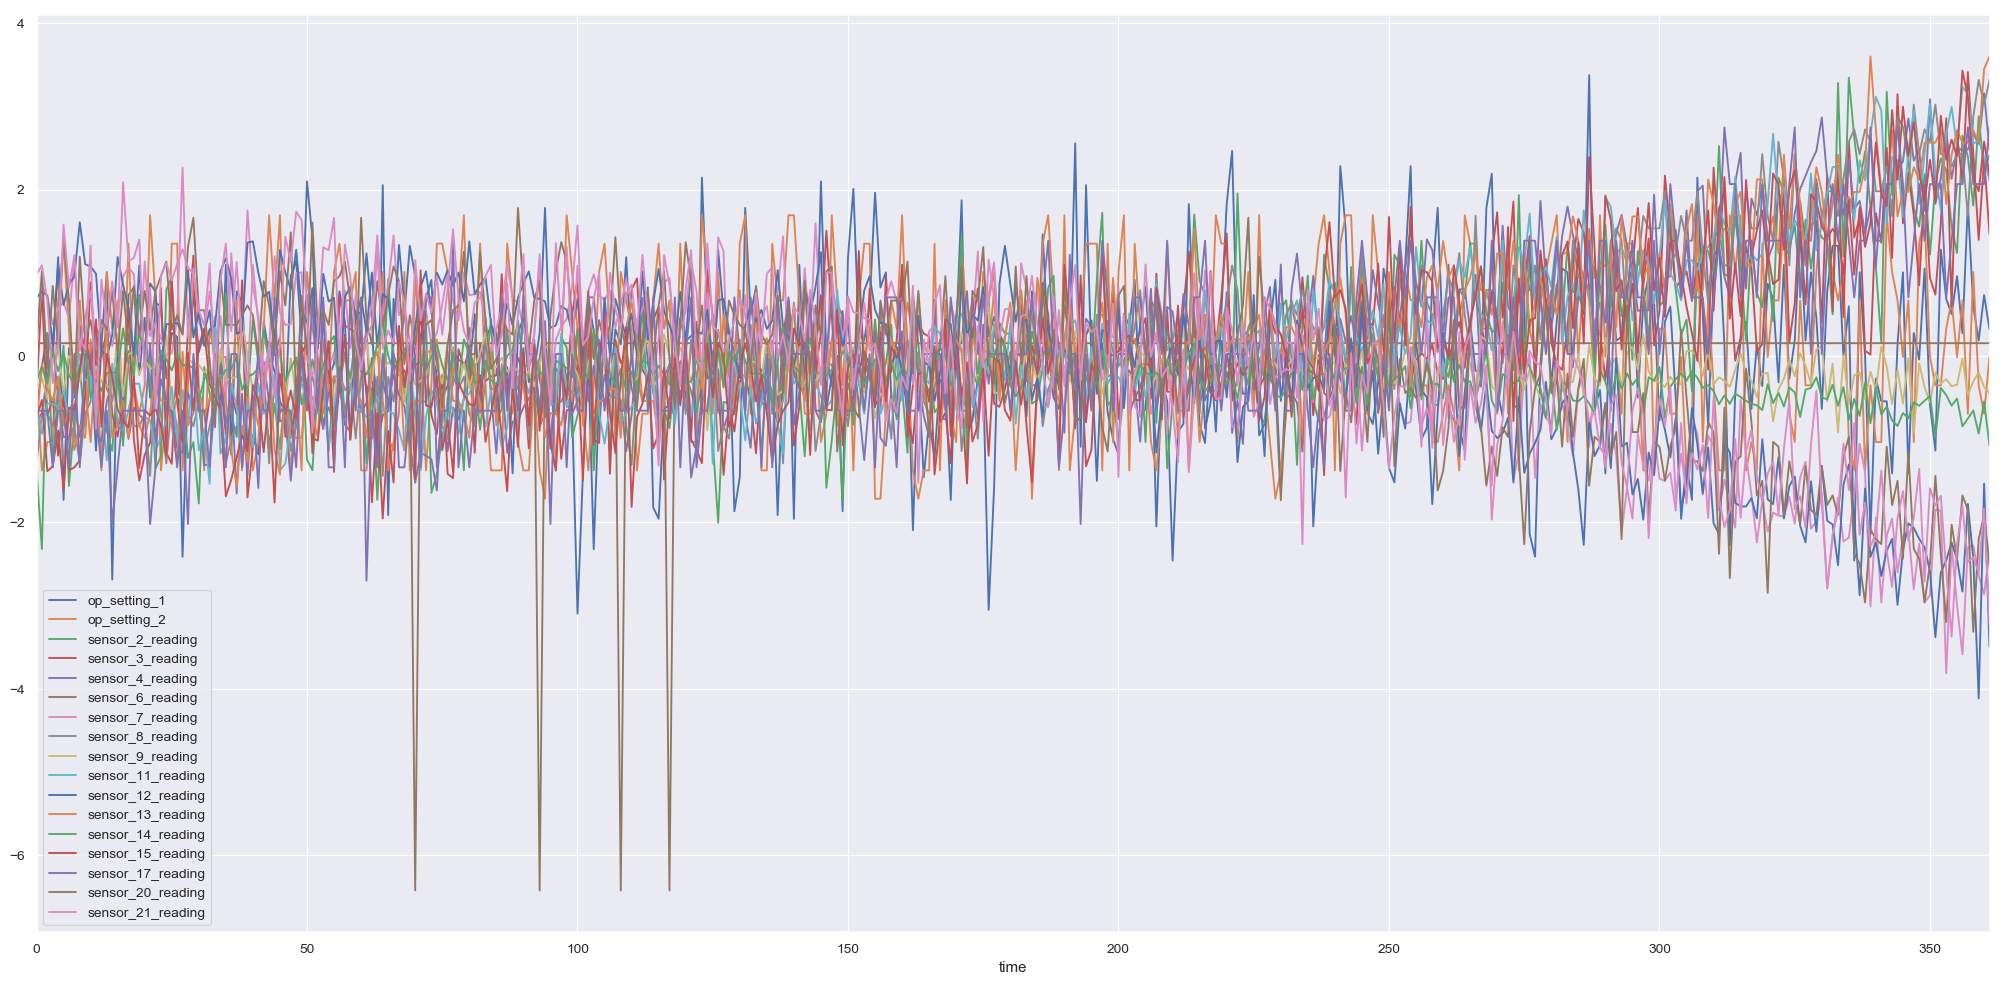

In [49]:
# import dask.dataframe as dd
to_dct = (train_.loc[unit_tmax, new_features])
train_.loc[unit_tmax, new_features].plot(figsize=(28,13.5))

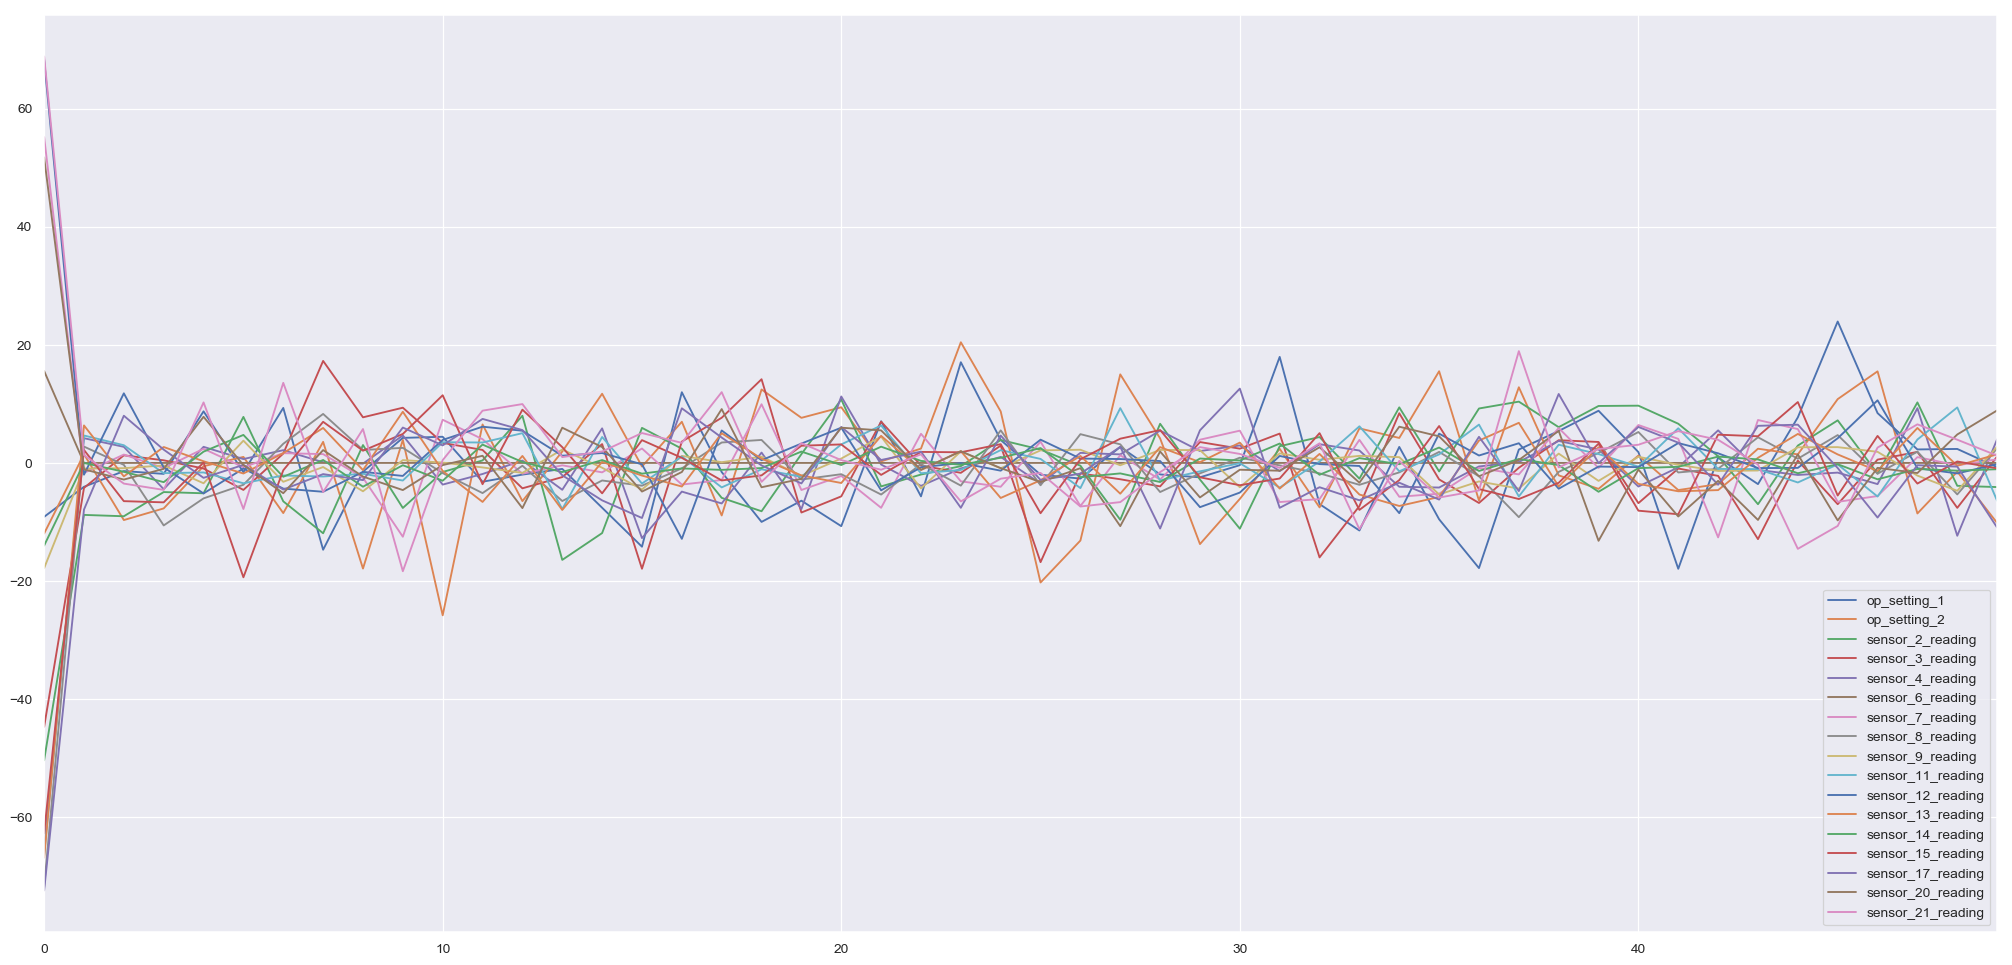

In [56]:
#to_dct.values = scipy
dct = pd.DataFrame(scipy.fftpack.dct(to_dct, axis=0, n=50), columns=to_dct.columns)
dct.plot(figsize=(28,13.5))

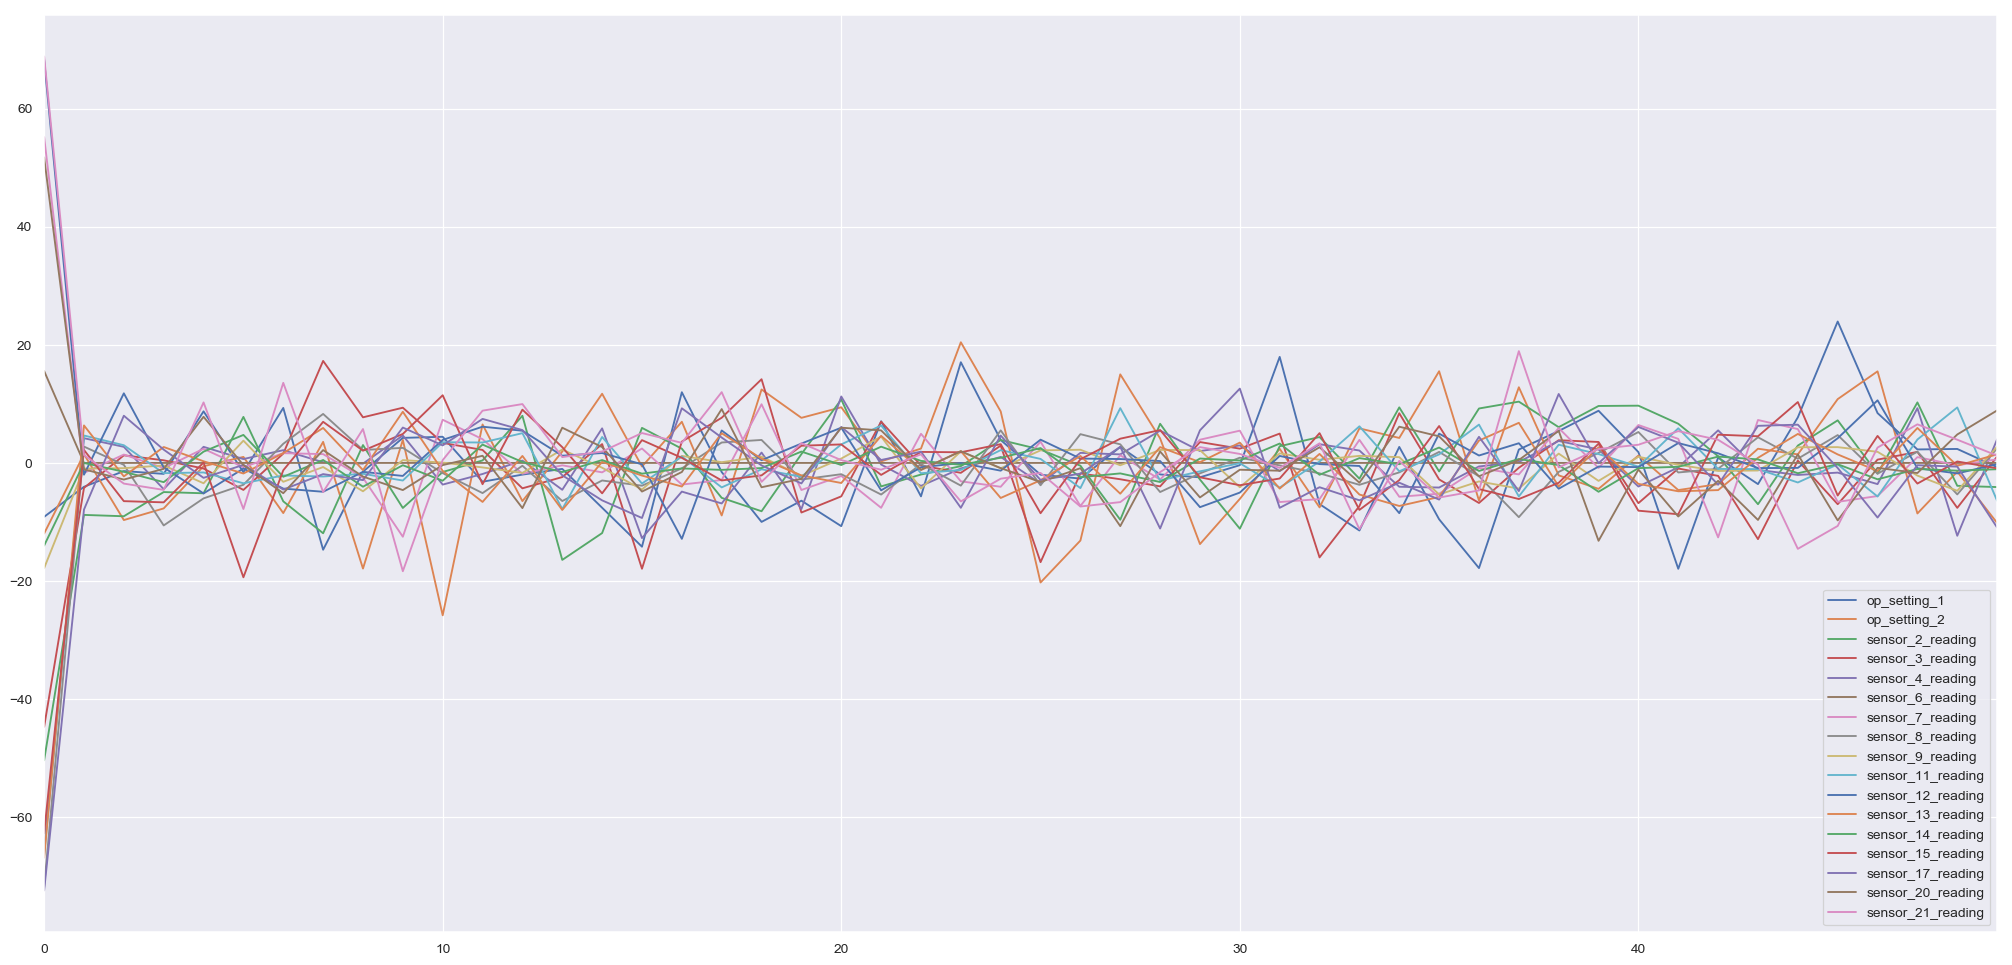

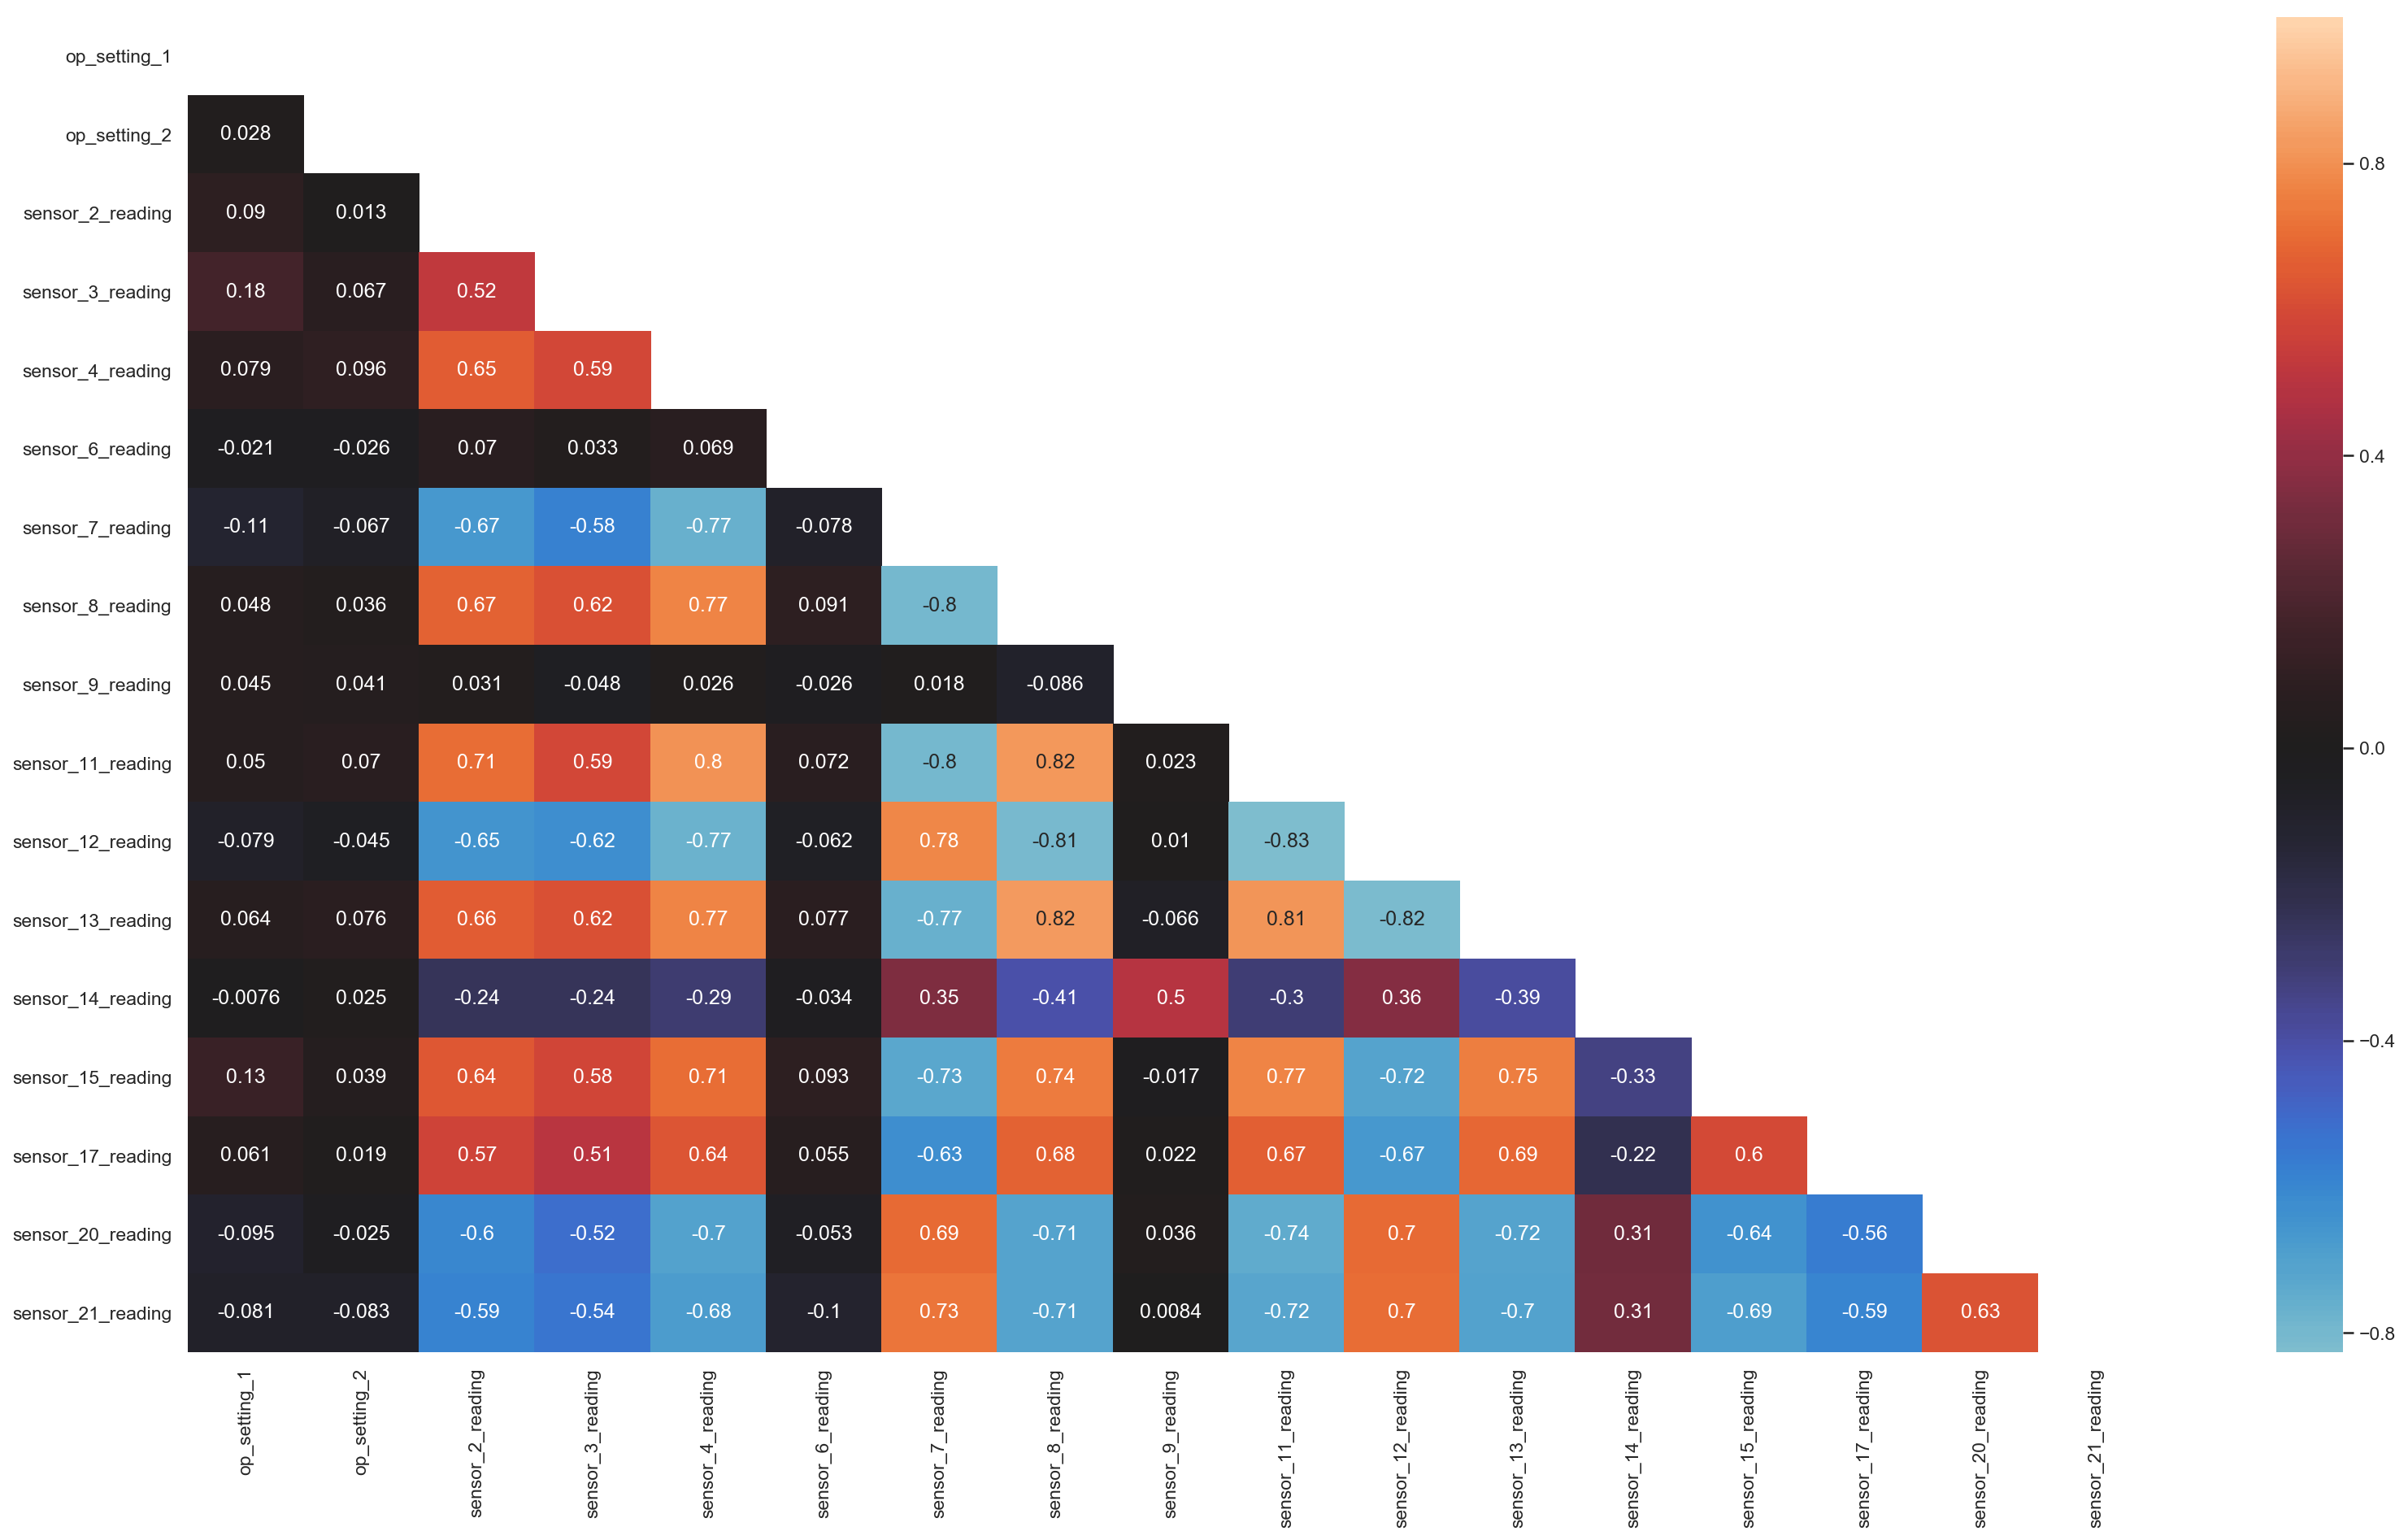

In [74]:
corr_sample = all_data_orig.loc[unit_tmax, new_features].corr()
mask = np.zeros_like(corr_sample)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(26,14.5))
    ax = sns.heatmap(corr_sample, mask=mask, ax=ax, annot=True, center=0)

In [46]:
grid = sns.pairplot(corrs_1, kind='reg', mask=mask, height=4, aspect=1)
grid.savefig('../images/corr.svg')

TypeError: pairplot() got an unexpected keyword argument 'mask'

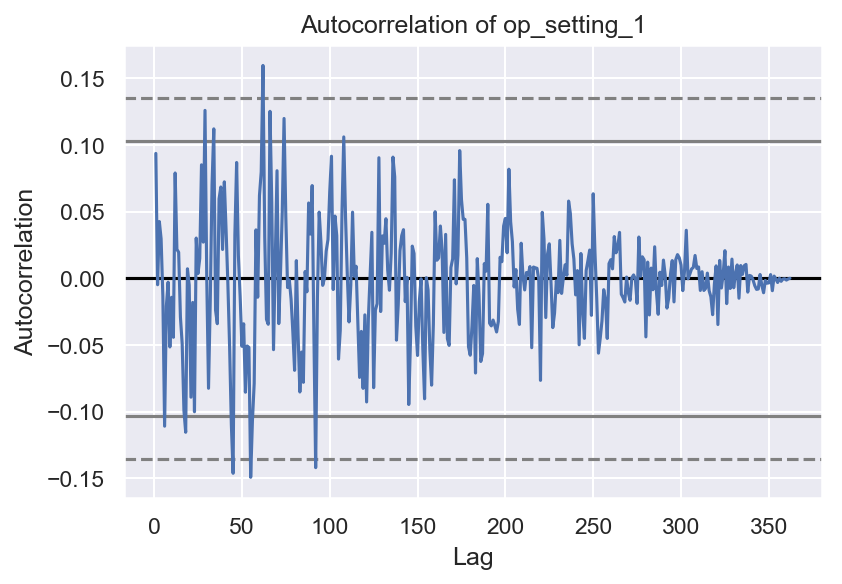

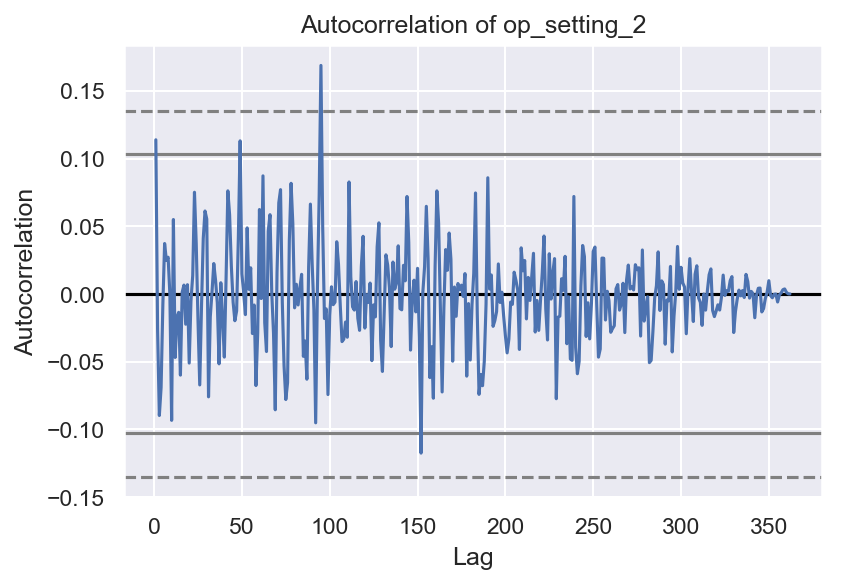

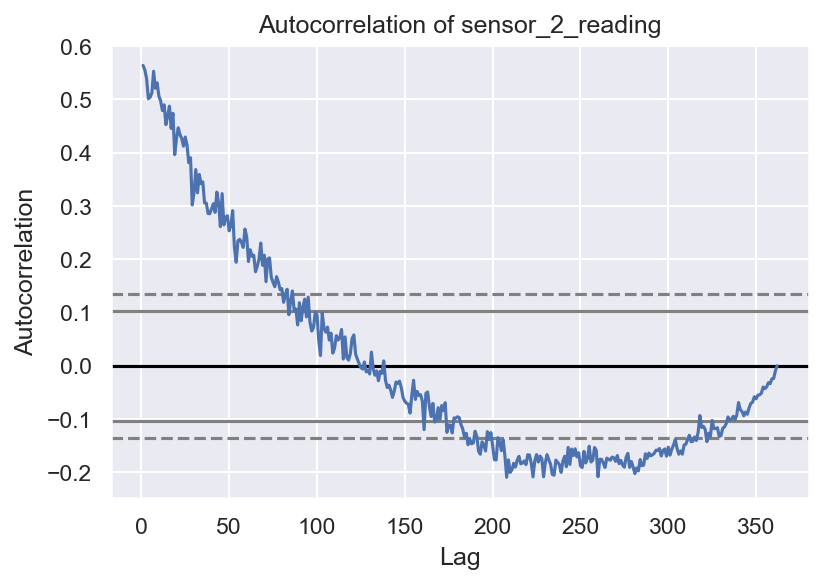

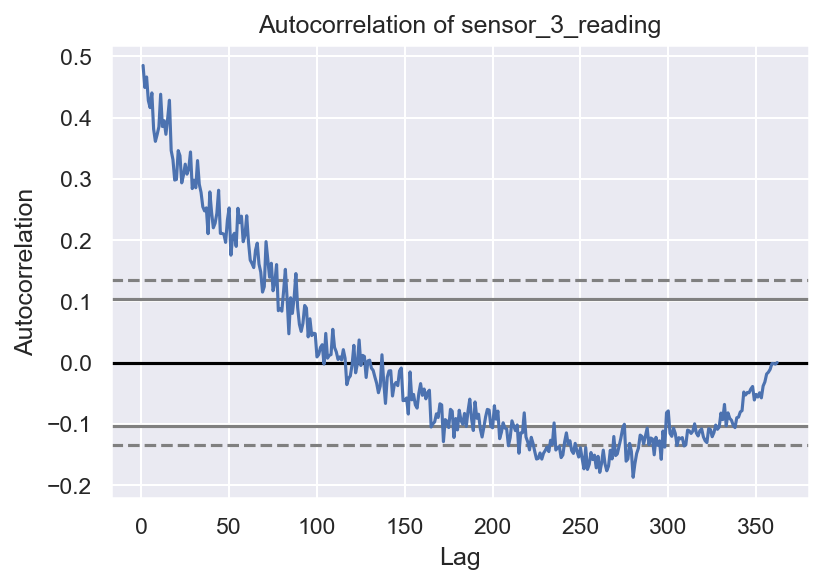

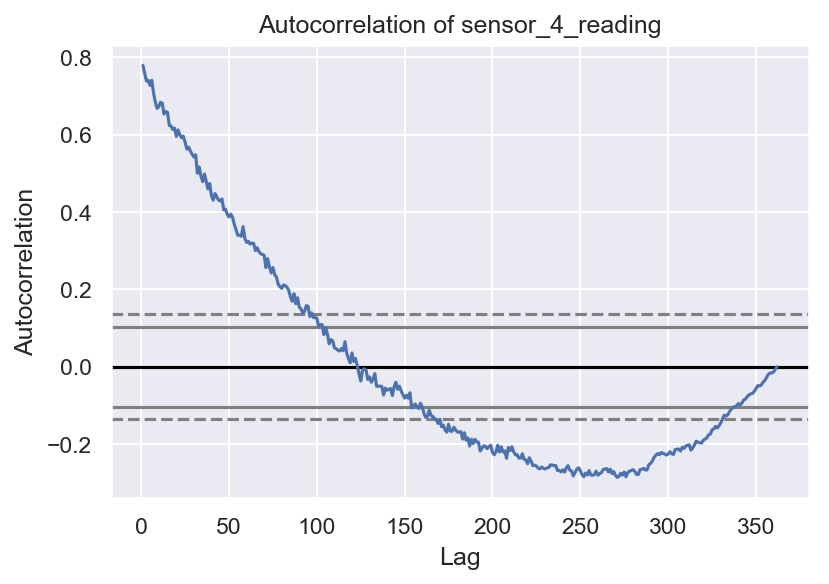

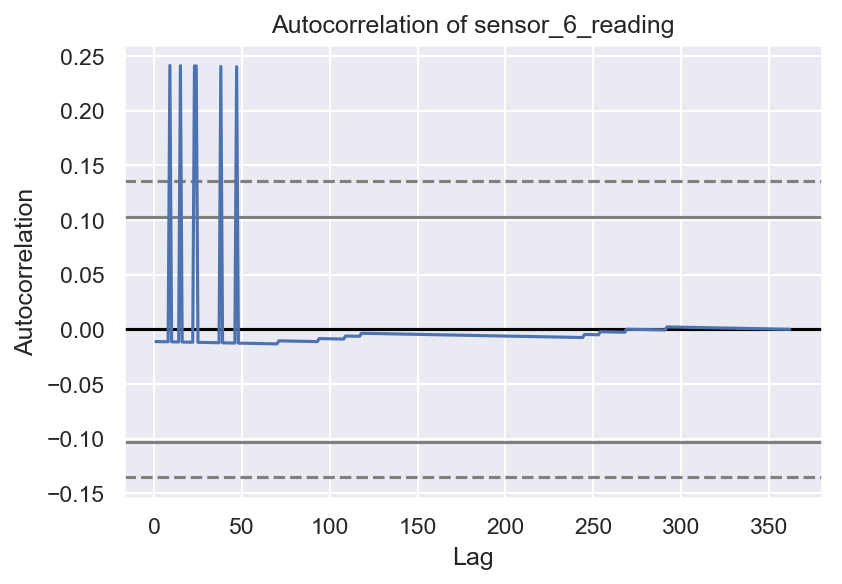

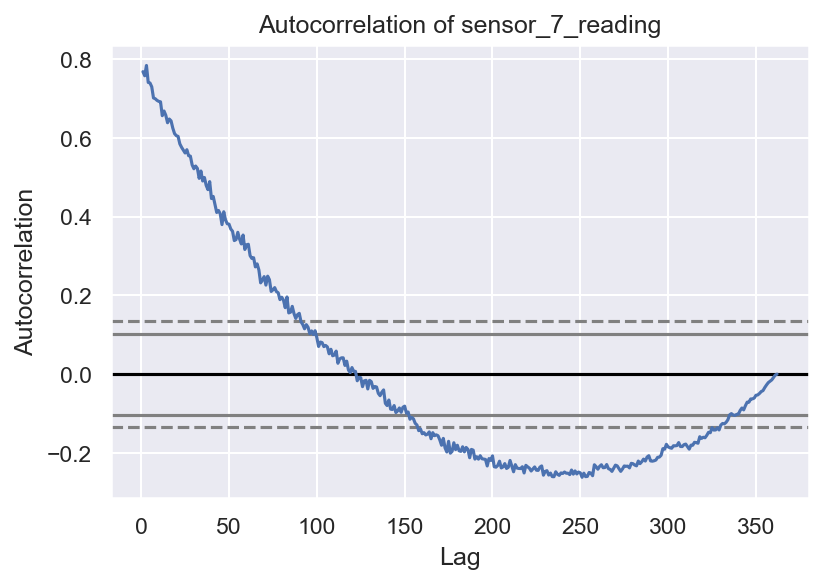

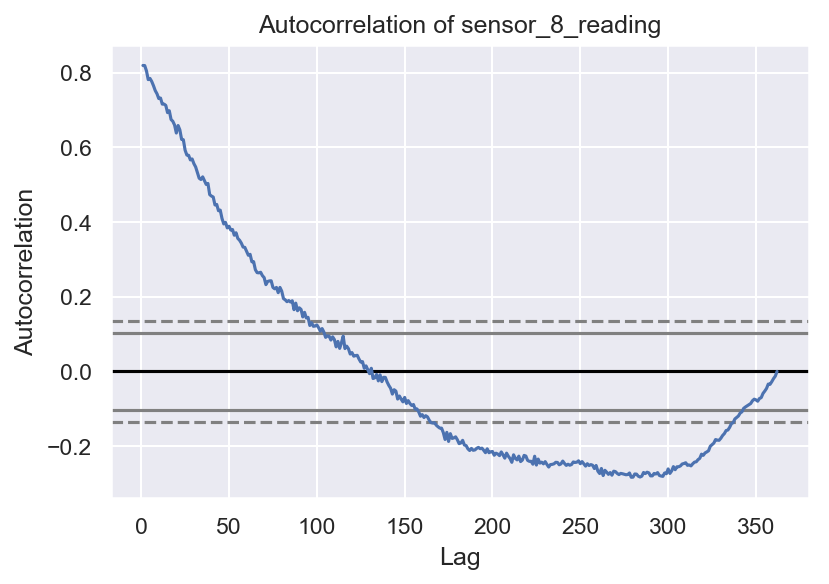

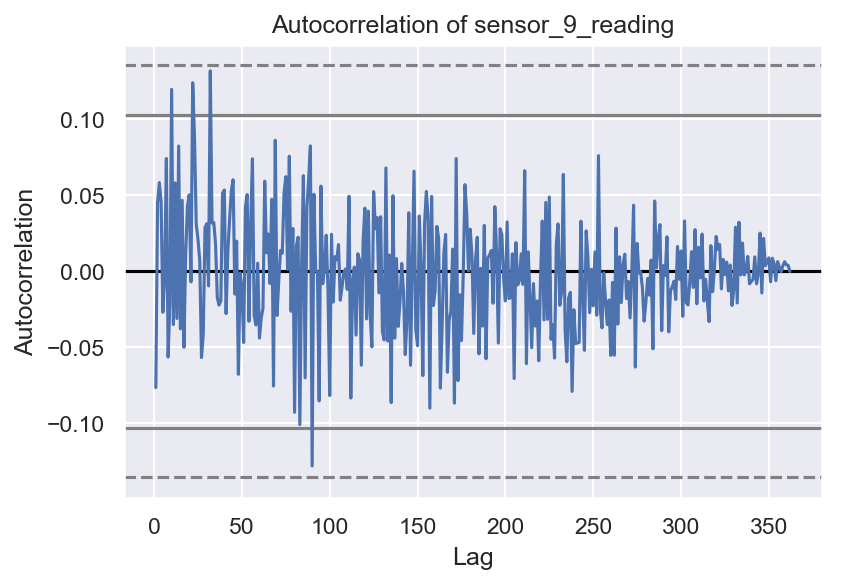

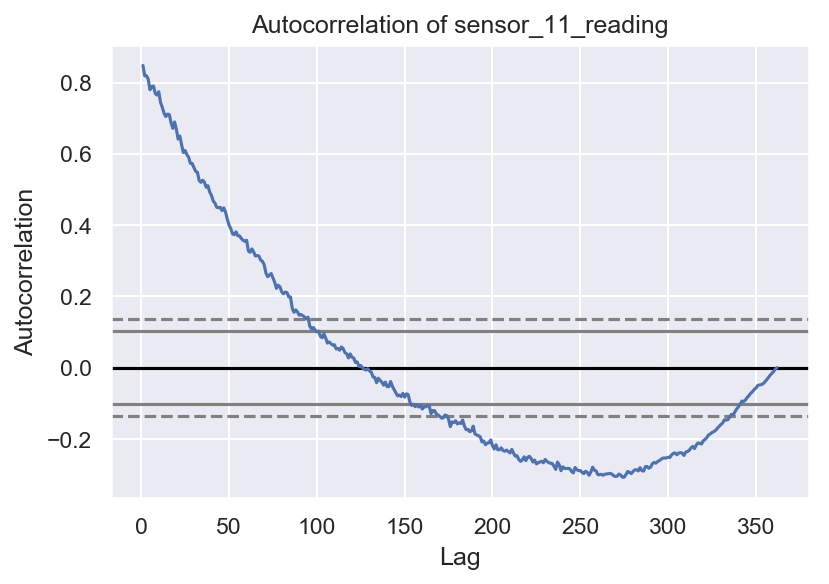

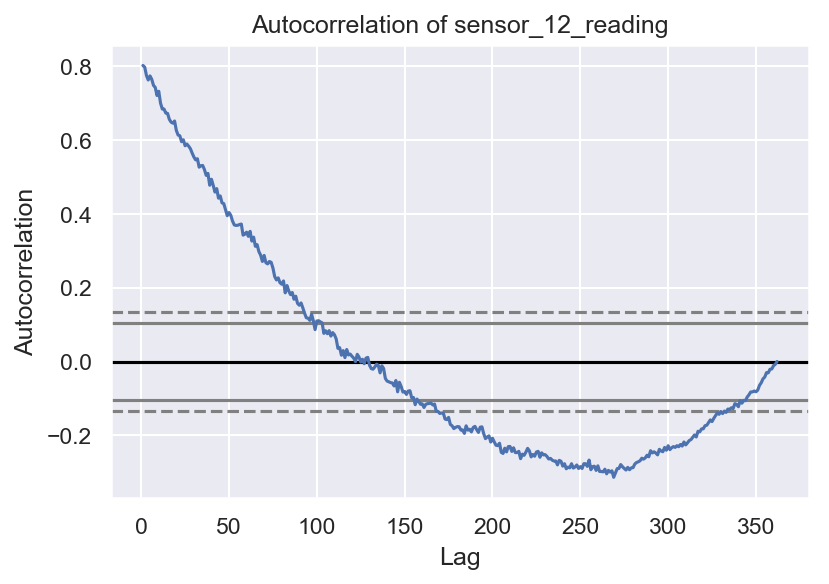

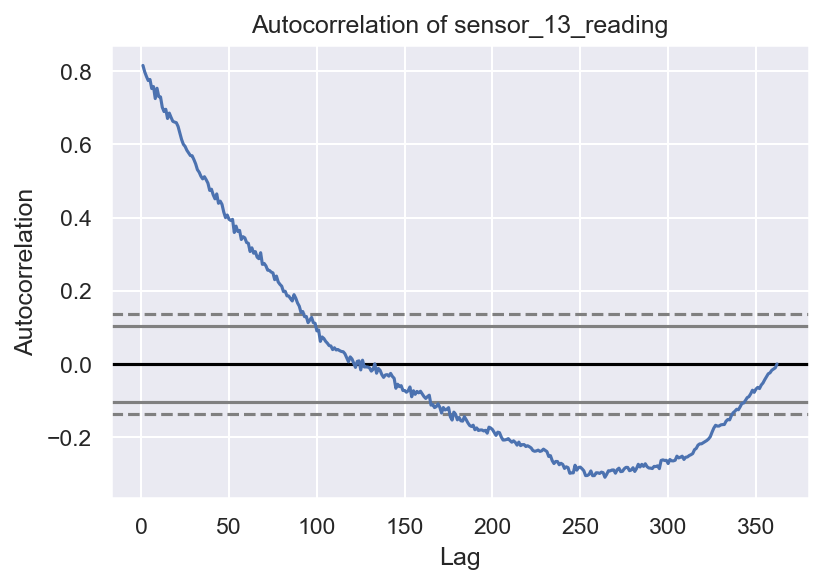

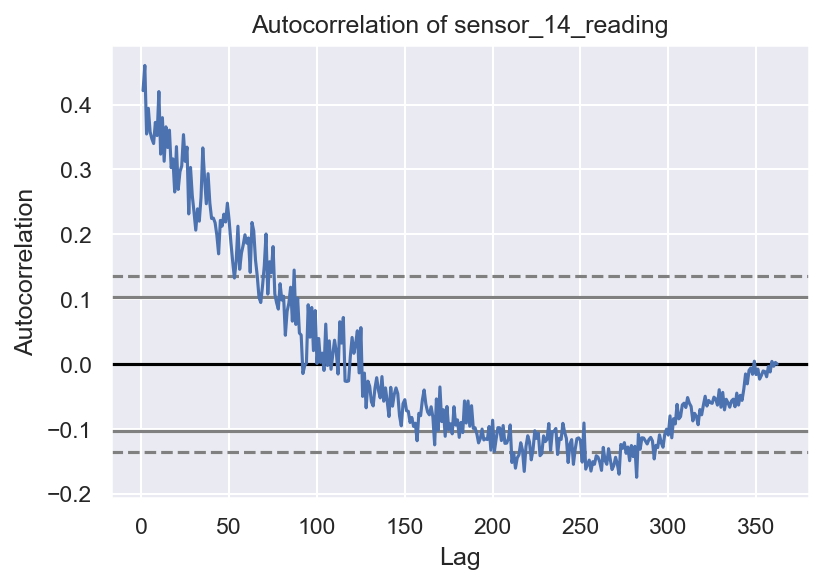

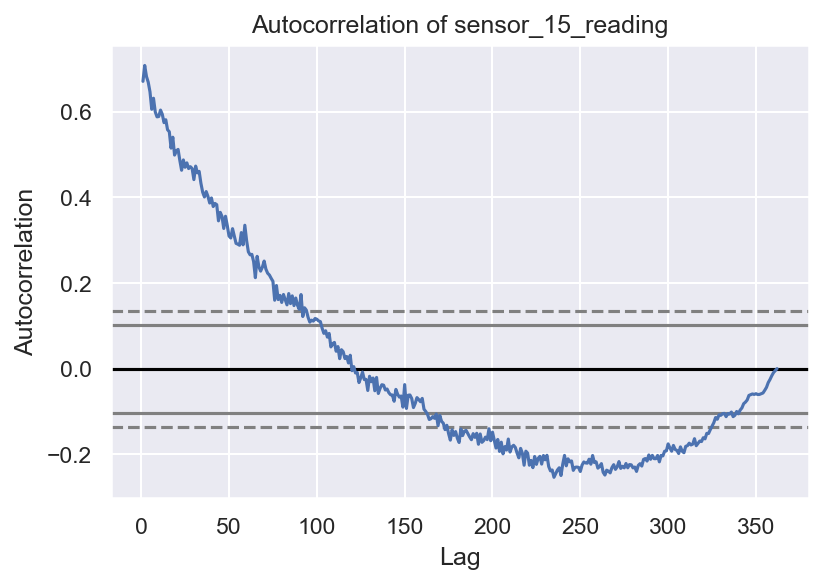

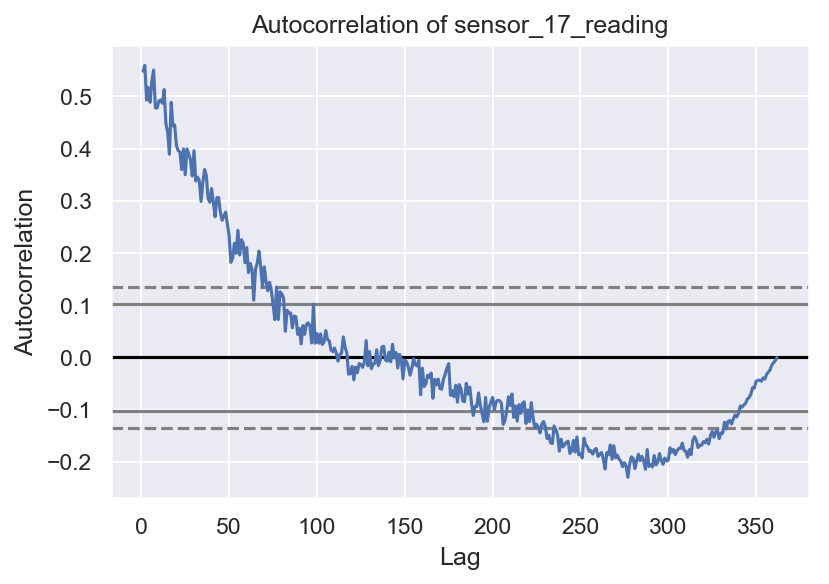

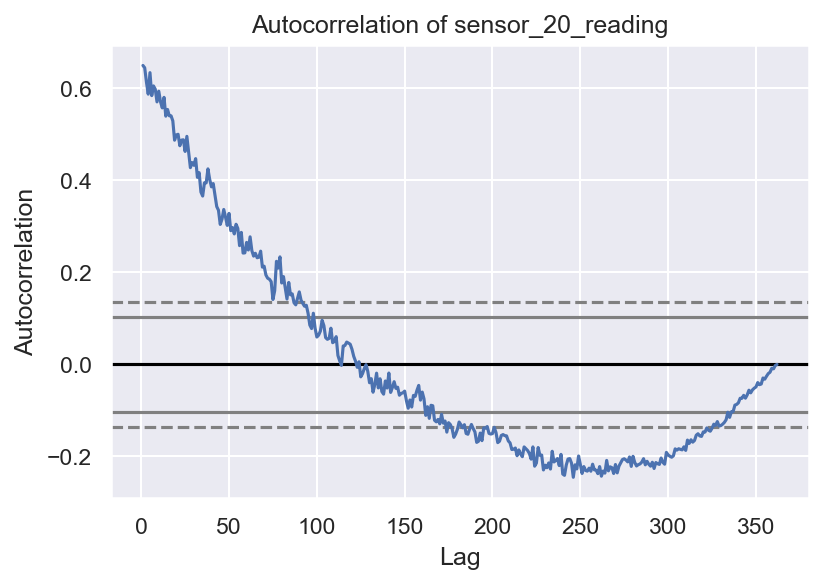

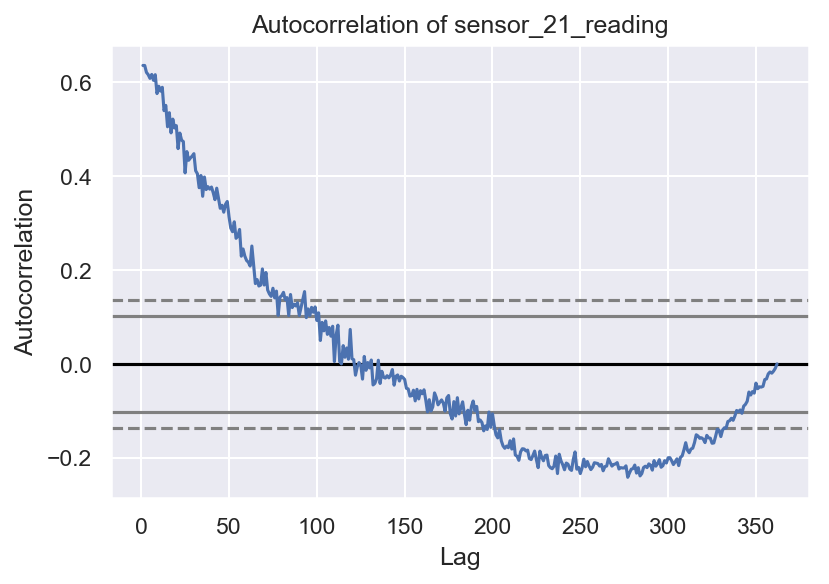

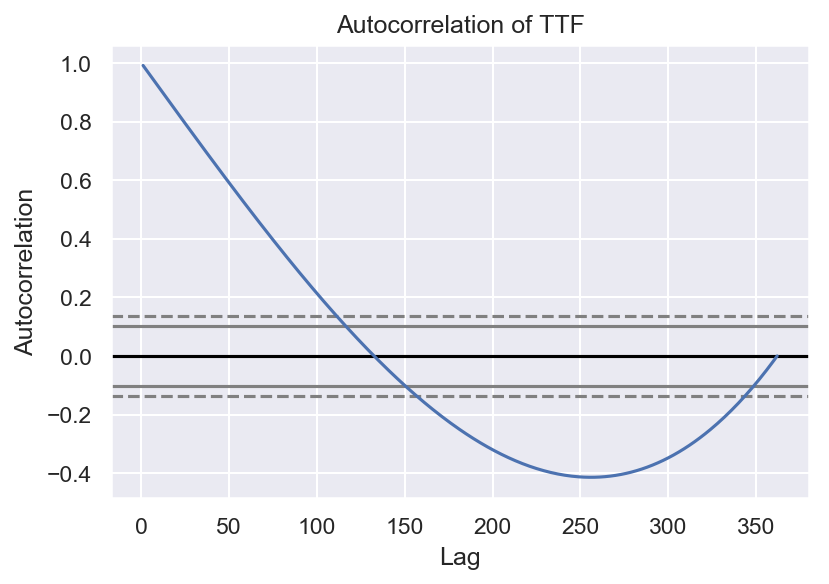

In [90]:
#plt.plot(np.correlate(train_.loc[0, 'sensor_2_reading'].values, train_.loc[0, 'sensor_2_reading'].values, 'full')[train_.loc[0, 'sensor_2_reading'].shape[0]+1:])
with sns.axes_style('dark'):
    for reading in train_.columns:
        fig, ax = plt.subplots()
        fig.figsize=(26,11.5)
        pd.plotting.autocorrelation_plot(train_.loc[unit_tmax, reading], ax=ax)
        ax.set_title("Autocorrelation of {}".format(reading))

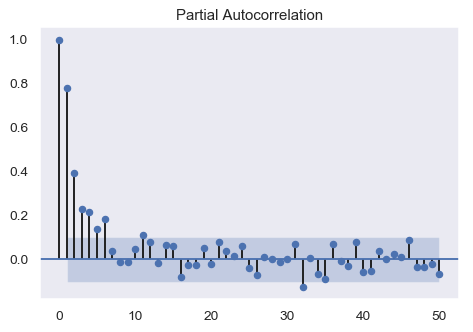

In [106]:
with sns.axes_style('dark'):
    statsmodels.graphics.tsaplots.plot_pacf(train_.loc[unit_tmax, "sensor_4_reading"], lags=50, alpha=.05)